In [2]:
import os
import numpy as np
import scipy.io
import scipy.signal
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pywt
import torch
import torch.nn as nn
%matplotlib inline

In [35]:
path = '../../data/spectral_denoising_data'

inputs = scipy.io.loadmat(os.path.join(path, 'Test_Inputs.mat'))
inputs = inputs['Test_Inputs']
outputs = scipy.io.loadmat(os.path.join(path, 'Test_Outputs.mat'))
outputs = outputs['Test_Outputs']

print(type(inputs))
print(inputs.shape)
print(outputs.shape)

<class 'numpy.ndarray'>
(12694, 500)
(12694, 500)


Noisy:


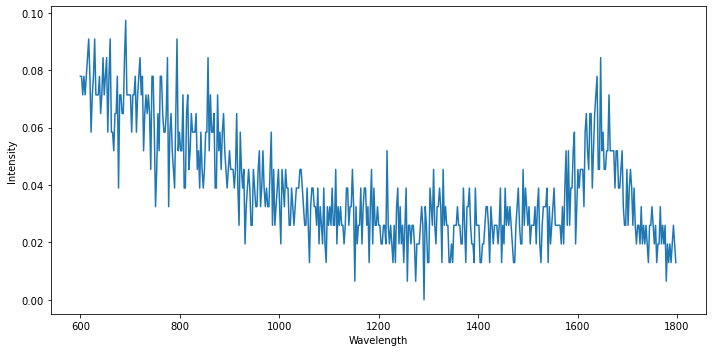

In [45]:
def plot_spec(spec, wl = None):
    wave = wl if wl is not None else np.arange(len(spec))
    fig, ax = plt.subplots(1,1,figsize = (10,5))
    ax.plot(wave, spec)
    ax.set_xlabel('Wavelength')
    ax.set_ylabel('Intensity')
    fig.tight_layout()
    plt.show()
    
wl = np.arange(600, 1800, (1800 - 600) / inputs.shape[1])
print('Noisy:')
plot_spec(inputs[0], wl)

Denoised:


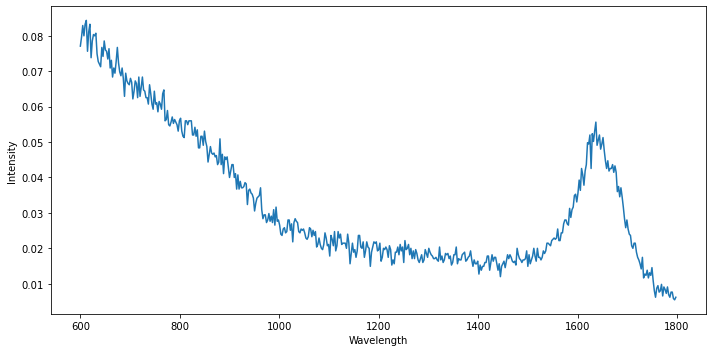

In [38]:
print('Denoised:')
plot_spec(outputs[0], wl)

Savitsky-Golay:


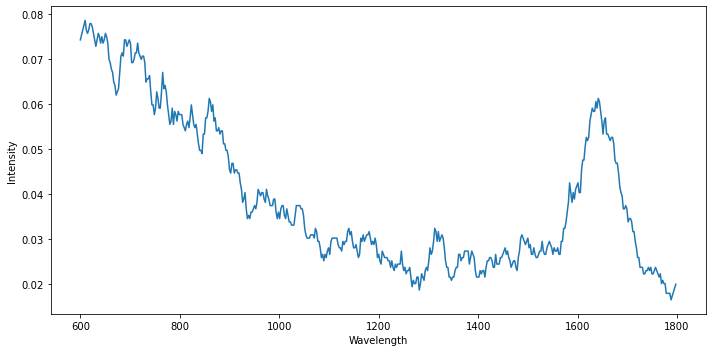

In [40]:
sg = scipy.signal.savgol_filter(inputs[0], 9 , 1)
print('Savitsky-Golay:')
plot_spec(sg, wl)

Padded with reflection:


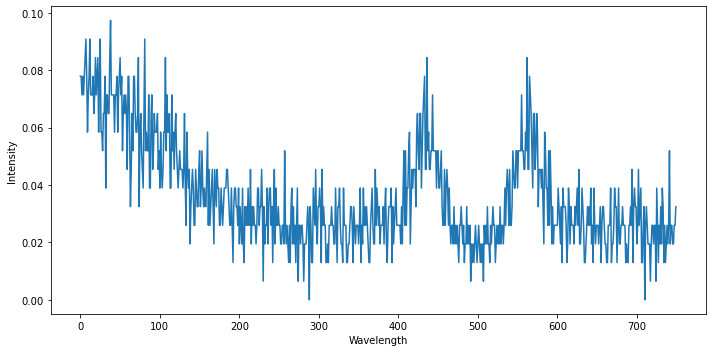

In [177]:
def pad_spectrum(input_spectrum, spectrum_length):
    if len(input_spectrum) == spectrum_length:
        padded_spectrum = input_spectrum
    elif len(input_spectrum) > spectrum_length:
        padded_spectrum = input_spectrum[0:spectrum_length]
    else:
        padded_spectrum = np.pad(input_spectrum, (0, spectrum_length - len(input_spectrum)), 'reflect')

    return padded_spectrum

pad = pad_spectrum(inputs[0], 750)
print('Padded with reflection:')
plot_spec(pad)

Windowed:


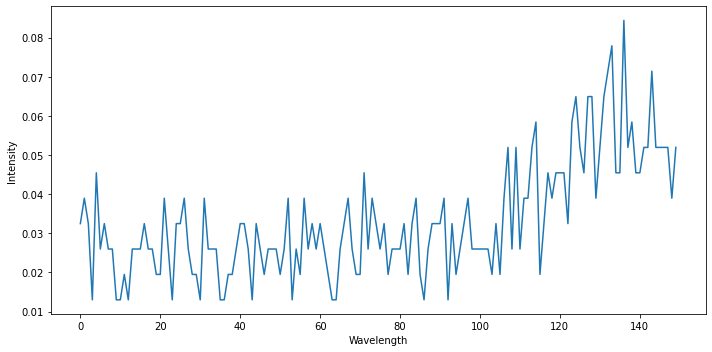

In [48]:
def window_spectrum(input_spectrum, start_idx, window_length):
    if len(input_spectrum) <= window_length:
        output_spectrum = input_spectrum
    else:
        end_idx = start_idx + window_length
        output_spectrum = input_spectrum[start_idx:end_idx]

    return output_spectrum

windowed = window_spectrum(inputs[0], 300, 150)
print('Windowed:')
plot_spec(windowed)

Flipped:


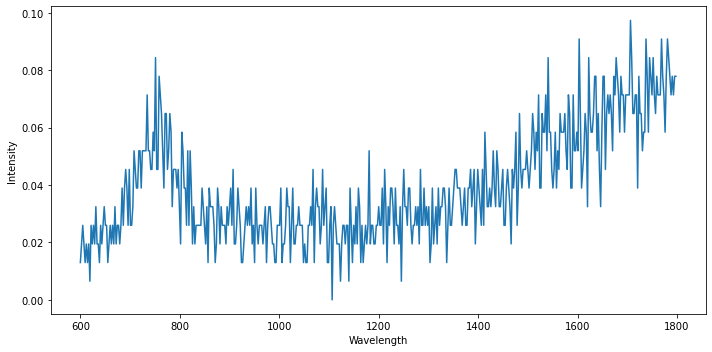

In [51]:
def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x

flipped = flip_axis(inputs[0], 0)
print('Flipped:')
plot_spec(flipped, wl)

Shifted:


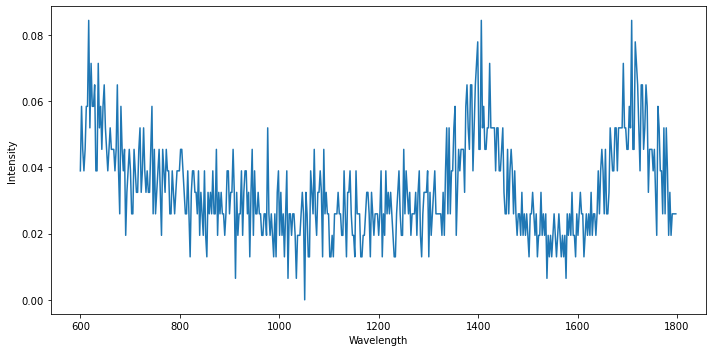

In [155]:
def shift_spectrum(x, shift_range):
    x = np.expand_dims(x,axis = -1)
    shifted_spectrum = x
    spectrum_shift_range = int(np.round(shift_range*len(x)))
    if spectrum_shift_range > 0:
        shifted_spectrum = np.pad(x[spectrum_shift_range:,:], ((0,abs(spectrum_shift_range)), (0,0)), 'reflect')
    elif spectrum_shift_range < 0:
        shifted_spectrum = np.pad(x[:spectrum_shift_range,:], ((abs(spectrum_shift_range), 0), (0,0)), 'reflect')
    return shifted_spectrum

shifted = shift_spectrum(inputs[0], 0.2)
print('Shifted:')
plot_spec(shifted, wl)

Mixed with another spectrum:


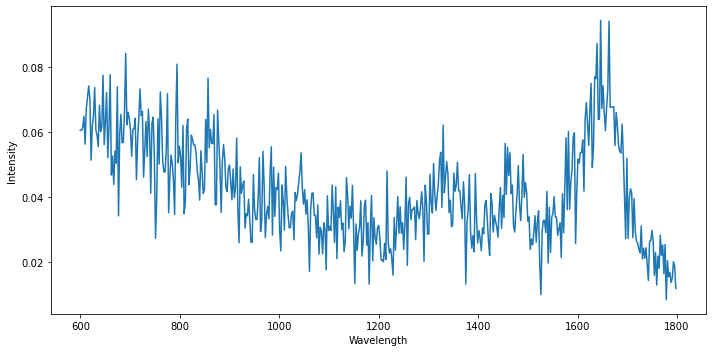

In [70]:
def mixup_spectrum(input_spectrum1, input_spectrum2, output_spectrum1, output_spectrum2, alpha):
    lam = np.random.beta(alpha, alpha)
    input_spectrum = (lam * input_spectrum1) + ((1 - lam) * input_spectrum2)
    output_spectrum = (lam * output_spectrum1) + ((1 - lam) * output_spectrum2)
    return input_spectrum, output_spectrum

mixed_input, _ = mixup_spectrum(inputs[0], inputs[10000], outputs[0], outputs[10000], 0.25)
print('Mixed with another spectrum:')
plot_spec(mixed_input, wl)

In [206]:
def center(spec):
    if spec.ndim == 1:
        spec = spec.reshape(1, len(spec))
    return spec - spec.mean(axis = 1).reshape(spec.shape[0], 1)

def scale(spec):
    if spec.ndim == 1:
        spec = spec.reshape(1, len(spec))
    return spec / spec.std(axis = 1).reshape(spec.shape[0], 1)

def min_max_scale(spec):
    if spec.ndim == 1:
        spec = spec.reshape(1, len(spec))
    spec_min = np.min(spec, axis = 1).reshape(spec.shape[0], 1)
    spec_max = np.max(spec, axis = 1).reshape(spec.shape[0], 1)
    return (spec - spec_min) / (spec_max - spec_min)

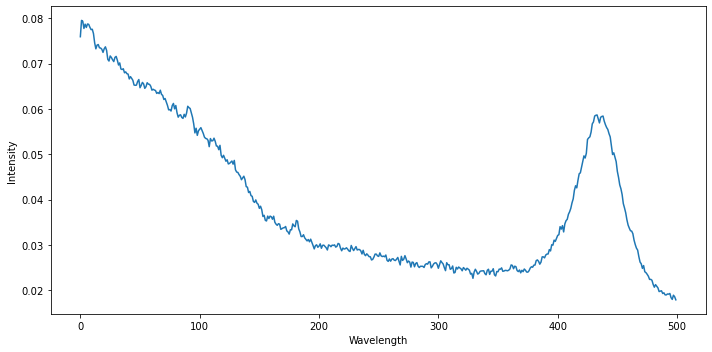

In [194]:
def pca_denoise(spec, n_components = 10):
    pca = PCA(n_components = n_components).fit(spec)
    components = pca.transform(spec)
    return pca.inverse_transform(components)

inputs_pca = pca_denoise(inputs, 10)
plot_spec(inputs_pca[0])

In [123]:
L1 = nn.L1Loss()
MSE = nn.MSELoss()
print('Original MAE:', L1(torch.tensor(inputs), torch.tensor(outputs)).numpy())
print('Original MSE:', MSE(torch.tensor(inputs), torch.tensor(outputs)).numpy())

Original MAE: 0.018899865785554693
Original MSE: 0.0005311820368833868


In [131]:
def calc_MSE(source, target):
    if source.ndim == 1:
        source = source.reshape(1, len(source))
        target = target.reshape(1, len(target))
    MSE = np.mean((source - target)**2, axis = 1)
    return np.mean(MSE)

def calc_MAE(source, target):
    if source.ndim == 1:
        source = source.reshape(1, len(source))
        target = target.reshape(1, len(target))
    MAE = np.mean(np.abs(source - target), axis = 1)
    return np.mean(MAE)

#calc_MAE(inputs, outputs)
calc_MSE(inputs, outputs)

0.0005311820368833869

In [192]:
def get_optimal_pca(source, target, max_components = 100):
    ''' 
    Calculate number of PCs that leads to smallest MSE for PCA denoising. 
    Return that MSE along with the optimal number of components.
    '''
    pca_mse = []
    for i in range(max_components):
        denoised = pca_denoise(source, n_components = i+1)
        MSE = calc_MSE(denoised, target)
        pca_mse.append(MSE)
    min_err_idx = np.argmin(pca_mse)
    return pca_mse[min_err_idx], min_err_idx + 1

get_optimal_pca(inputs, outputs)

(0.00037886289866663535, 5)

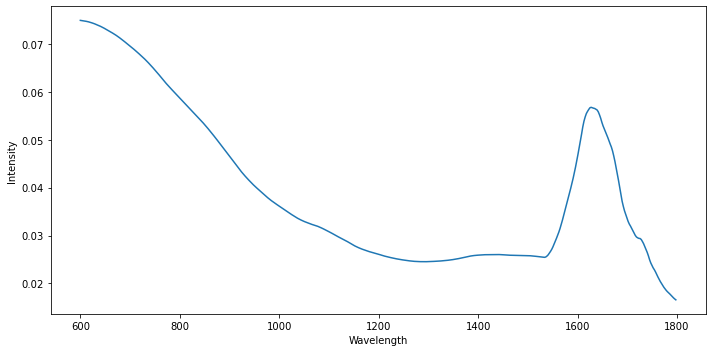

In [293]:
def wavelet_denoise(spec, wavelet = 'db4', level = 1, mode = 'symmetric', threshold = 'hard'):
    if spec.ndim == 1:
        spec = spec.reshape(1, len(spec))
    n, spec_len = spec.shape
        
    # mean absolute deviation
    def maddev(x):
        return np.mean(np.absolute(x - np.mean(x, axis = 1).reshape(n, 1)), axis = 1)
    
    # get wavelet coefficients
    coeff = pywt.wavedec(spec, wavelet, mode = mode)
    
    # calculate and apply thresholds
    sigma = (1 / 0.6745) * maddev(coeff[-level])
    uthresh = (sigma * np.sqrt(2 * np.log(spec_len))).reshape(n, 1)
    coeff[1:] = (pywt.threshold(i, value = uthresh, mode = threshold) for i in coeff[1:])
    
    # Reconstruct signal using thresholded coefficients
    return pywt.waverec(coeff, wavelet, mode = mode)

inputs_wavelet = wavelet_denoise(inputs, level = 1)
plot_spec(inputs_wavelet[0], wl)

In [294]:
def get_optimal_wavelet(source, target, max_level = 3):
    ''' 
    Calculate wavelet type/level that leads to smallest MSE for wavelet denoising. 
    Return that MSE along with the wavelet type and decomposition level.
    '''
    if source.ndim == 1:
        source = source.reshape(1, len(source))
        target = target.reshape(1, len(target))
    n, spec_len = source.shape
    
    wavelet_mse = []
    wavelet_type = []
    wavelet_level = []
    for wavelet in pywt.wavelist(kind = 'discrete'):
        # calculate max useful level of decomposition for wavelet type
        max_useful_level = pywt.dwt_max_level(spec_len, wavelet)
        max_to_use = min(max_useful_level, max_level) if max_level is not None else max_useful_level
        for lev in range(max_to_use):
            # get reconstructed (denoised) spectra
            denoised = wavelet_denoise(source, wavelet = wavelet, level = lev+1)
            MSE = calc_MSE(denoised, target)
            wavelet_mse.append(MSE)
            wavelet_type.append(wavelet)
            wavelet_level.append(lev + 1)
            
    min_err_idx = np.argmin(wavelet_mse)
    return wavelet_mse[min_err_idx], wavelet_type[min_err_idx], wavelet_level[min_err_idx]

get_optimal_wavelet(inputs, outputs)

(0.00039412043737647816, 'rbio2.8', 1)

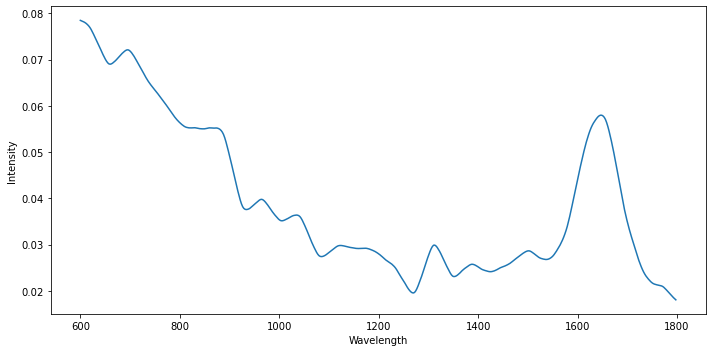

In [295]:
inputs_wavelet = wavelet_denoise(inputs, wavelet = 'rbio2.8', level = 1)
plot_spec(inputs_wavelet[0], wl)